In [418]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys

project_basedir = '..'
sys.path.append(project_basedir)
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
from net import resnet
import common
from gameplays import gameplay,players
from gameplays.analysis import get_km_json
import json
%matplotlib inline
gpu_core = 6
import os
import random
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_core)

In [406]:
!date

2018年 10月 12日 星期五 23:28:42 CST


In [443]:
! ls -l '../data/validate/2018-10-12_19-50-14_noup/' | tail

-rw-rw-r-- 1 meta meta  2653 10月 12 21:18 2018-10-12_21-18-26_729_mcts-mcts_oldnet-newnet_w.cbf
-rw-rw-r-- 1 meta meta  4328 10月 12 21:19 2018-10-12_21-19-22_540_mcts-mcts_oldnet-newnet_b.cbf
-rw-rw-r-- 1 meta meta  3778 10月 12 21:19 2018-10-12_21-19-28_179_mcts-mcts_newnet-oldnet_b.cbf
-rw-rw-r-- 1 meta meta  3178 10月 12 21:19 2018-10-12_21-19-31_866_mcts-mcts_newnet-oldnet_b.cbf
-rw-rw-r-- 1 meta meta  5428 10月 12 21:20 2018-10-12_21-20-20_362_mcts-mcts_oldnet-newnet_b.cbf
-rw-rw-r-- 1 meta meta  5203 10月 12 21:22 2018-10-12_21-22-00_425_mcts-mcts_oldnet-newnet_w.cbf
-rw-rw-r-- 1 meta meta  4728 10月 12 21:22 2018-10-12_21-22-10_579_mcts-mcts_oldnet-newnet_b.cbf
-rw-rw-r-- 1 meta meta  6128 10月 12 21:25 2018-10-12_21-25-01_623_mcts-mcts_newnet-oldnet_b.cbf
-rw-rw-r-- 1 meta meta  7753 10月 12 21:25 2018-10-12_21-25-49_413_mcts-mcts_newnet-oldnet_peace.cbf
-rw-rw-r-- 1 meta meta  8428 10月 12 21:30 2018-10-12_21-30-05_949_mcts-mcts_newnet-oldnet_peace.cbf


In [494]:
path = '../data/validate/2018-10-01_02-40-25_noup//'

In [495]:
gameplays = os.listdir(path)

In [496]:
fullpath = '{}{}'.format(path,random.choice(gameplays))
moves = cbf.cbf2move(fullpath)
fname = fullpath.split('/')[-1]
print(fname)
state = gameplay.GameState()

2018-10-01_03-09-51_338_mcts-mcts_newnet-oldnet_w.cbf


In [497]:
from PIL import Image
import imageio
imgs_for_gif = []
state = gameplay.GameState()
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
for i in moves[:]: 
    statestr = GameBoard.sim_do_action(i,statestr)
    imgs_for_gif.append(board_visualizer.get_board_img(statestr))
    state.do_move(i)
imgs_for_gif = imgs_for_gif[:]
imageio.mimsave('../data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

In [498]:
i,len(moves)

('d7d8', 130)

In [499]:
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))

In [500]:
display_gif('../data/gif/{}.gif'.format(fname[:-4]))

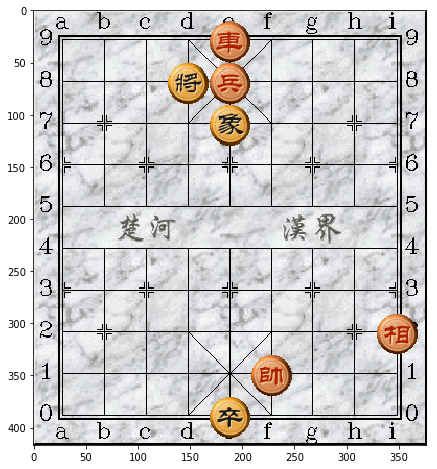

In [501]:
plt.figure(figsize=(8,8))
plt.imshow(board_visualizer.get_board_img(statestr))

# ANALYSIS

In [382]:
network = resnet.get_model(os.path.join(project_basedir,
    '../data/prepare_weight/2018-10-11_21-00-13_noup'[3:]),
    common.board.create_uci_labels(),GPU_CORE=[gpu_core],FILTERS=128,NUM_RES_LAYERS=7)

0
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
inside res net [None, 10, 9, 128]
INFO:tensorflow:Restoring parameters from ../data/prepare_weight/2018-10-11_21-00-13_noup


In [464]:
network_player = players.NetworkPlayer(state.currentplayer,network,n_playout=400,dnoise=False,c_puct=5)

In [ ]:
network_player.make_move(state=state,actual_move=False)

In [ ]:
network_player.mcts_policy._root._Q

In [ ]:
childs = network_player.mcts_policy._root._children
probs = []
for move in childs:
    val = childs[move]
    print(move,val._n_visits,val._P,val._Q)
    probs.append(val._n_visits)

In [ ]:
plt.plot(probs)
print(probs)

In [ ]:
plt.plot(probs)

In [393]:
sum(probs)

399

In [185]:
datajson = get_km_json(network_player.mcts_policy,state.statestr,depth=40)

In [196]:
!mkdir '../data/mstc_vis'

mkdir: 无法创建目录"../data/mstc_vis": 文件已存在


In [197]:
with open('../data/mstc_vis/sample.km','w') as whdl:
    json.dump(datajson,whdl)